In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test pipeline on one instance


In [12]:
from pathlib import Path
import librosa
import IPython.display as ipd
from pitch_estimator import PitchEstimator
from preprocessors import Preprocessor
import matplotlib.pyplot as plt
import scipy
import numpy as np

In [13]:
data_path = Path("gamelan_music_dataset")
targets_first = data_path / "first ensemble/orchestra/target"
audio_file_path = targets_first / "demung/001.wav"

pitch_est = PitchEstimator()
pp = Preprocessor()

# Display input audio
y, sr = librosa.load(audio_file_path, duration=10)
print('Input audio:')
display(ipd.Audio(y, rate=sr))

# Using median filtering to divide harmonic from percussive component
spectrogram = pp.compute_spectrogram(y)
harmonic, percussive = pp.apply_median_filtering(spectrogram)


# Reconstruct harmonic component audio and display it
reconstructed_audio_griffinlim = librosa.griffinlim(harmonic)
reconstructed_audio_griffinlim_percussive = librosa.griffinlim(percussive)

# https://librosa.org/doc/main/generated/librosa.griffinlim.html
print('Harmonic component reconstructed with griffin and lim algorithm:')
display(ipd.Audio(reconstructed_audio_griffinlim, rate=sr))


Input audio:


Harmonic component reconstructed with griffin and lim algorithm:


In [14]:
onsets = librosa.onset.onset_detect(y=reconstructed_audio_griffinlim_percussive, units="time")

In [15]:
onsets

array([0.65015873, 1.50929705, 2.36843537, 3.2275737 , 4.08671202,
       4.92263039, 5.78176871, 6.64090703, 7.50004535, 8.35918367,
       9.218322  ])

In [16]:
time, frequency, confidence, activation = pitch_est.estimate_crepe(reconstructed_audio_griffinlim, sr)


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step


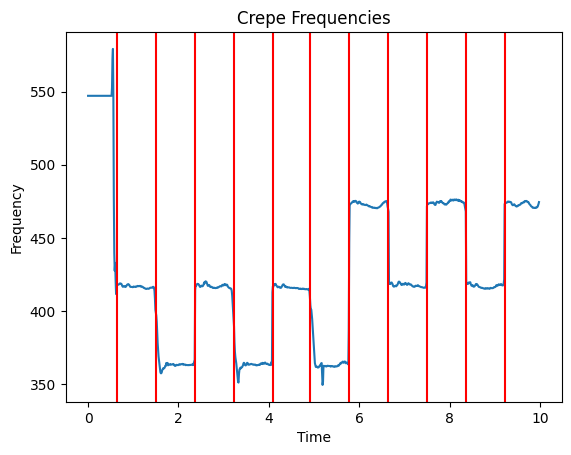

In [18]:
# Plot the interpolated frequencies
plt.plot(time, frequency)
plt.xlabel('Time') 
plt.ylabel('Frequency')
plt.title('Crepe Frequencies')

for t in onsets:
    plt.axvline(x=round(t, 2), color='r', linestyle='-', label=f'Time {t}')

plt.show()

In [51]:
tones = []
for i, onset in enumerate(onsets):
    index_a = np.argmax(time > onset)
    if i == len(onsets) - 1: index_b = len(time) - 1
    else: index_b = np.argmax(time > onsets[i+1])
    frequency_range = frequency[index_a:index_b]
    tone = np.median(frequency_range)
    print(f'Onset {i}-{i+1}: {tone}')
    tones.append(tone)

Onset 0-1: 416.67615886083297
Onset 1-2: 363.36099490215474
Onset 2-3: 417.0591462394804
Onset 3-4: 363.55933962408346
Onset 4-5: 415.92396540571974
Onset 5-6: 362.6504981874357
Onset 6-7: 472.8484153951698
Onset 7-8: 417.8205009187541
Onset 8-9: 474.3581757904353
Onset 9-10: 417.25448587349024
Onset 10-11: 473.0498264479651


In [65]:
sorted_tones = sorted(tones)

In [67]:
def group_and_average_frequencies(frequencies, threshold=10):
    grouped_frequencies = []
    current_group = [frequencies[0]]
    
    for i in range(1, len(frequencies)):
        if frequencies[i] - frequencies[i-1] <= threshold:
            current_group.append(frequencies[i])
        else:
            grouped_frequencies.append(sum(current_group) / len(current_group))
            current_group = [frequencies[i]]
    
    grouped_frequencies.append(sum(current_group) / len(current_group))
    
    return grouped_frequencies

In [68]:
grouped_averaged_frequencies = group_and_average_frequencies(sorted_tones)
print(grouped_averaged_frequencies)

[363.19027757122467, 416.9468514596555, 473.41880587785676]
